In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from pytorch_lightning import LightningModule, Trainer
from sklearn.model_selection import train_test_split

import albumentations as A
import matplotlib.pyplot as plt
import pandas as pd

import cv2
import os

%matplotlib inline

In [2]:
torch.cuda.is_available()

True

In [3]:
from services.service import visualize_bbox, visualize
from services.augmentations import get_training_augmentation, get_val_augmentation
from services.model import FasterRCNN, DetectionDataset, collate_fn


BOX_COLOR = (255, 0, 0)  # Red
TEXT_COLOR = (255, 255, 255)  # White

In [4]:
data = pd.read_csv('my_data.csv')
data.head()

Unnamed: 0                                              image    xmin  \
0           0  ../Road_Signs_Screens/4/NO20220705-134422-0000...  1468.0   
1           1  ../Road_Signs_Screens/4/NO20220705-134422-0000...  1693.0   
2           2  ../Road_Signs_Screens/4/NO20220705-134422-0000...  1720.0   
3           3  ../Road_Signs_Screens/4/NO20220705-134422-0000...  2008.0   
4           4  ../Road_Signs_Screens/4/NO20220705-134422-0000...  1591.0   

    ymin    xmax   ymax    name               class  
0  748.0  1518.0  797.0  5.16.2  Informational_sign  
1  384.0  1833.0  505.0  5.16.2  Informational_sign  
2  707.0  1767.0  760.0    3.27        Warning_sign  
3  534.0  2064.0  603.0    3.27     Forbidding_sign  
4  849.0  1632.0  895.0  5.16.2  Informational_sign

In [5]:
data = data.drop(data.columns[0], axis=1)

<AxesSubplot: >

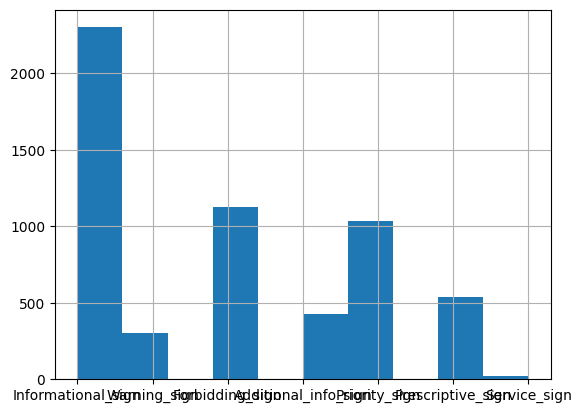

In [6]:
data['class'].hist()

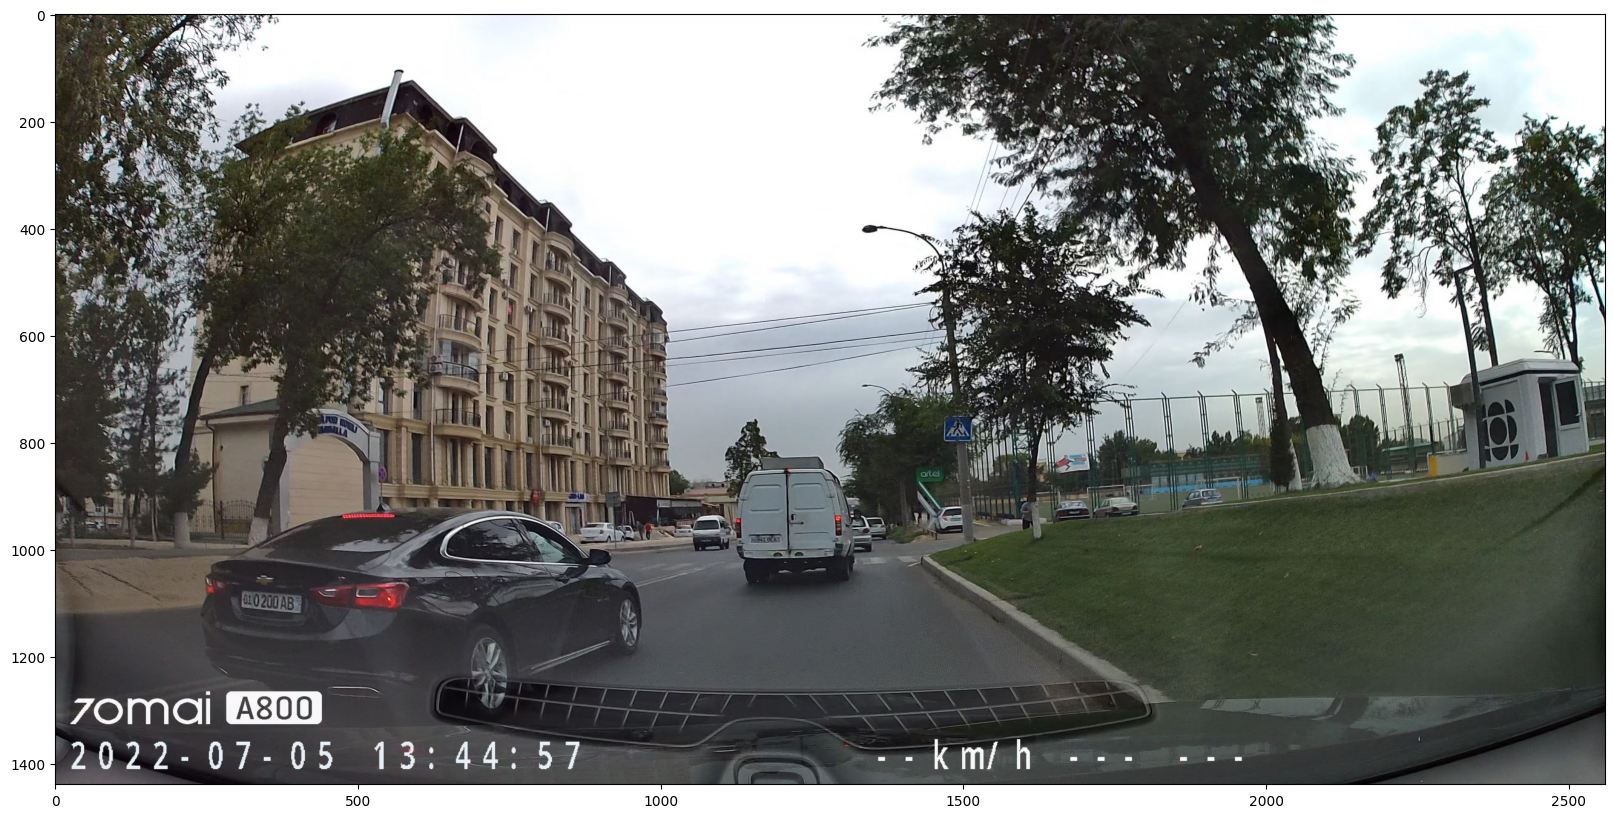

In [7]:
im = cv2.imread(data['image'][0])
im = cv2.cvtColor(im, cv2.COLOR_RGB2BGR)
plt.figure(figsize=(20, 10))
plt.imshow(im, aspect='auto')

In [8]:
uniq = data['class'].unique()
len_uniq = len(uniq) + 1
range_uniq = range(1, len_uniq + 1)
str_to_num = dict(zip(uniq, range_uniq))
num_to_str = dict(zip(range_uniq, uniq))
str_to_num, num_to_str

({'Informational_sign': 1,
  'Warning_sign': 2,
  'Forbidding_sign': 3,
  'Additional_info_sign': 4,
  'Priority_sign': 5,
  'Prescriptive_sign': 6,
  'Service_sign': 7},
 {1: 'Informational_sign',
  2: 'Warning_sign',
  3: 'Forbidding_sign',
  4: 'Additional_info_sign',
  5: 'Priority_sign',
  6: 'Prescriptive_sign',
  7: 'Service_sign'})

In [9]:
def get_num(label):
    return str_to_num[label]

In [10]:
data['class'] = data['class'].apply(get_num)
data.head()

image    xmin   ymin    xmax  \
0  ../Road_Signs_Screens/4/NO20220705-134422-0000...  1468.0  748.0  1518.0   
1  ../Road_Signs_Screens/4/NO20220705-134422-0000...  1693.0  384.0  1833.0   
2  ../Road_Signs_Screens/4/NO20220705-134422-0000...  1720.0  707.0  1767.0   
3  ../Road_Signs_Screens/4/NO20220705-134422-0000...  2008.0  534.0  2064.0   
4  ../Road_Signs_Screens/4/NO20220705-134422-0000...  1591.0  849.0  1632.0   

    ymax    name  class  
0  797.0  5.16.2      1  
1  505.0  5.16.2      1  
2  760.0    3.27      2  
3  603.0    3.27      3  
4  895.0  5.16.2      1

<AxesSubplot: ylabel='Frequency'>

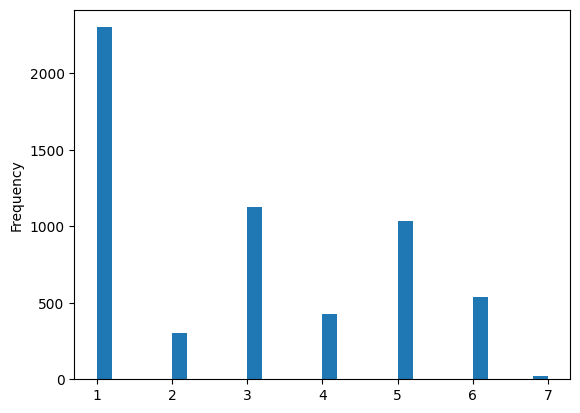

In [11]:
data['class'].plot.hist(bins=30)

In [12]:
train, val = train_test_split(data, test_size=0.30, stratify=data['class'])
train.reset_index(inplace=True, drop=True)
train = train['image'].unique()
val.reset_index(inplace=True, drop=True)
val = val['image'].unique()


In [13]:
transform_train = get_training_augmentation(960, 1080)
tranfrorm_val = get_val_augmentation(960, 1080)

In [14]:
train_set = DetectionDataset(data, train, '',
                             transform_train
                             )
val_set = DetectionDataset(data, val, '',
                           tranfrorm_val
                           )

In [15]:
im, targets = val_set[40]
im.shape, targets


(torch.Size([3, 1080, 960]),
 {'boxes': tensor([[577.3007, 482.0000, 612.8192, 583.0000],
          [ 36.0188, 547.0000,  49.0255, 591.0000]]),
  'labels': tensor([1, 1])})

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


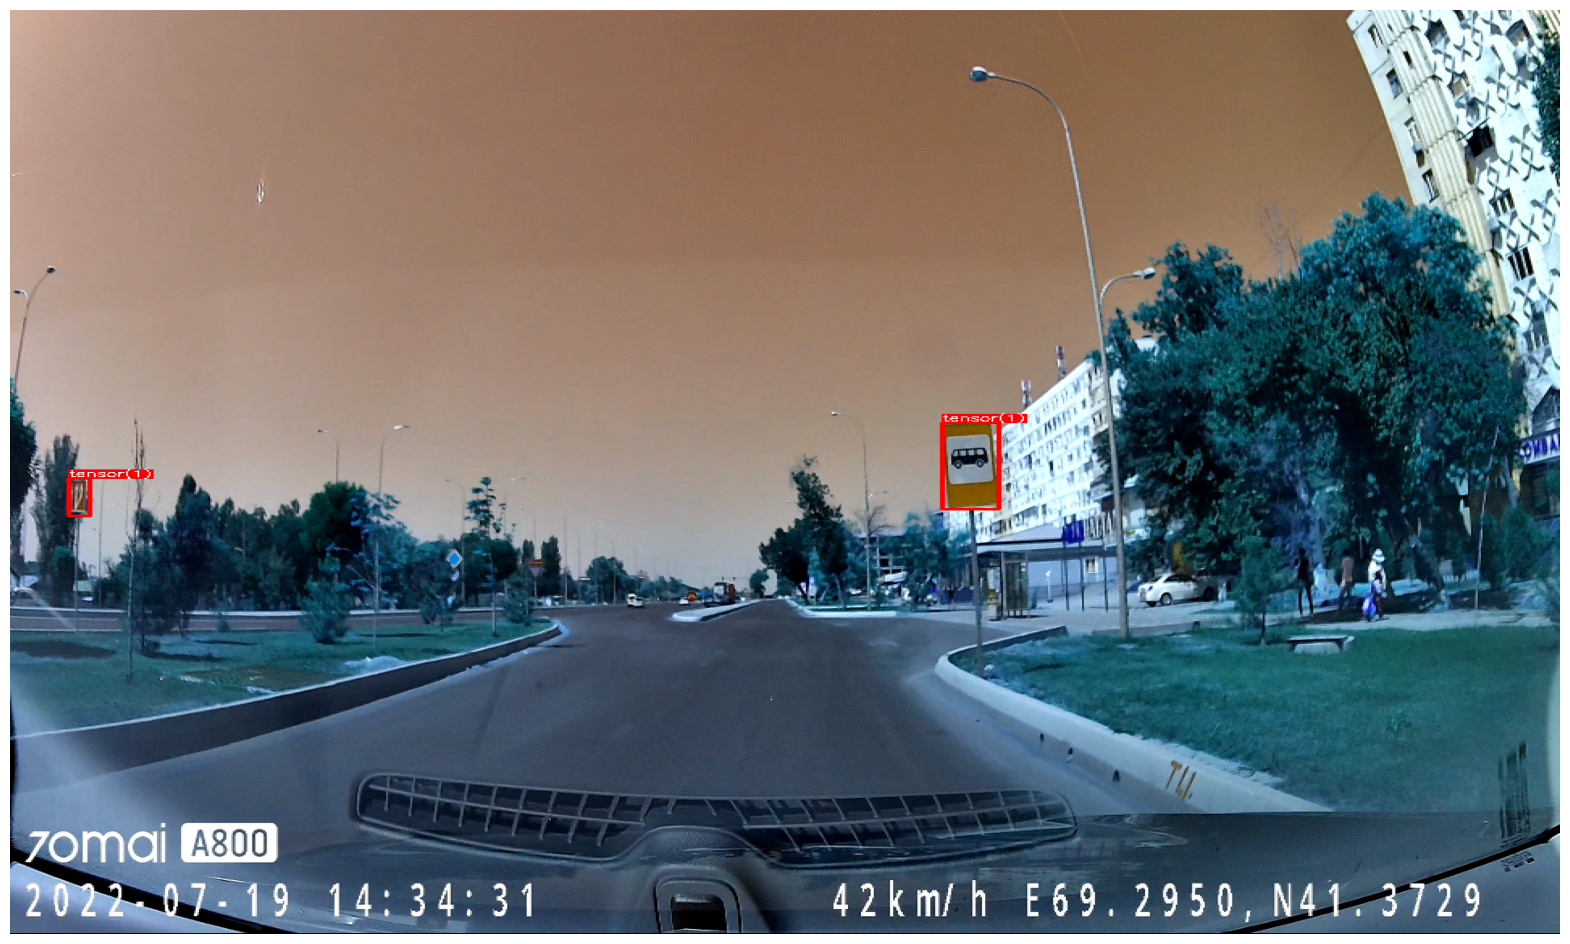

In [16]:
visualize(im.permute(1, 2, 0).numpy(), targets['boxes'], targets['labels'])

In [17]:
data_loader = torch.utils.data.DataLoader(
    train_set, batch_size=8, shuffle=True, num_workers=20, collate_fn=collate_fn,
)
val_loader = torch.utils.data.DataLoader(
    val_set, batch_size=4, num_workers=12, collate_fn=collate_fn,
)

In [18]:
det_model = FasterRCNN(len_uniq)

In [19]:
# det_model = torch.compile(det_model)

In [19]:
from pytorch_lightning.callbacks import ModelCheckpoint
path_loc = f'{len_uniq}class_v1'
checkpoint_callback = ModelCheckpoint(
    dirpath=f"../lightning_logs/detection/{path_loc}", save_top_k=2, monitor="val_epoch_total_step", mode='max')


In [20]:
trainer = Trainer(accelerator='gpu', devices=1,
                  max_epochs=100,
                  callbacks=[checkpoint_callback],
                  default_root_dir=f'../lightning_logs/detection/{path_loc}'
                  )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [21]:
trainer.fit(det_model,
            data_loader, val_loader,
            )

Missing logger folder: ../lightning_logs/detection/8class_v1/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type                 | Params
--------------------------------------------------
0 | detector | FasterRCNN           | 43.3 M
1 | metric   | MeanAveragePrecision | 0     
--------------------------------------------------
43.1 M    Trainable params
225 K     Non-trainable params
43.3 M    Total params
173.148   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/tim/.local/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:85: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 3. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/home/tim/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [22]:
det_model = det_model.to('cpu')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


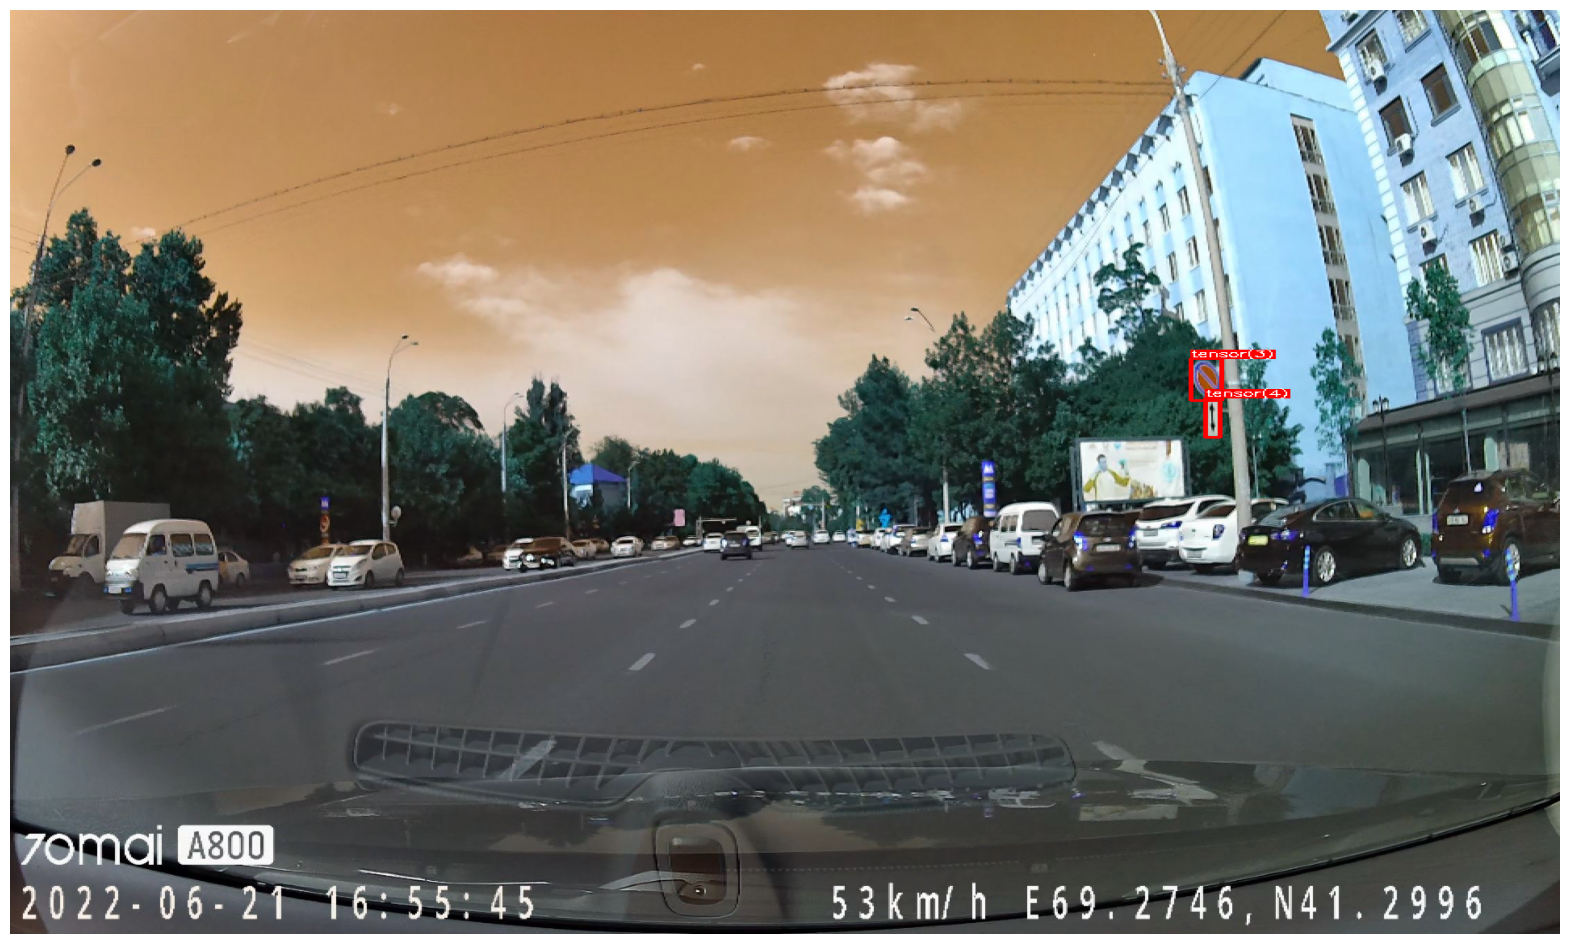

In [47]:
im,targets = val_set[124]
visualize(im.permute(1, 2, 0).numpy(), targets['boxes'], targets['labels'])

In [48]:
ret = det_model([im])

In [49]:
ret[0]

{'boxes': tensor([[738.5900, 449.9082, 751.4266, 502.0406],
         [731.2535, 409.8729, 750.1699, 452.1192],
         [891.7487, 312.7051, 941.8849, 369.9458],
         [536.6239, 579.5620, 547.3582, 614.1574],
         [893.2277, 311.2479, 943.6123, 377.8312],
         [738.9817, 453.9920, 749.9427, 481.9114],
         [666.7946, 341.4745, 696.7304, 400.5419],
         [892.5407, 313.0925, 941.4799, 369.8392],
         [191.5492, 589.1021, 198.8776, 613.2401],
         [893.0331, 313.8730, 942.0688, 368.9663]], grad_fn=<StackBackward0>),
 'labels': tensor([4, 3, 3, 5, 5, 4, 3, 1, 6, 4]),
 'scores': tensor([0.9960, 0.9957, 0.3155, 0.2608, 0.2467, 0.0982, 0.0841, 0.0766, 0.0621,
         0.0520], grad_fn=<IndexBackward0>)}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


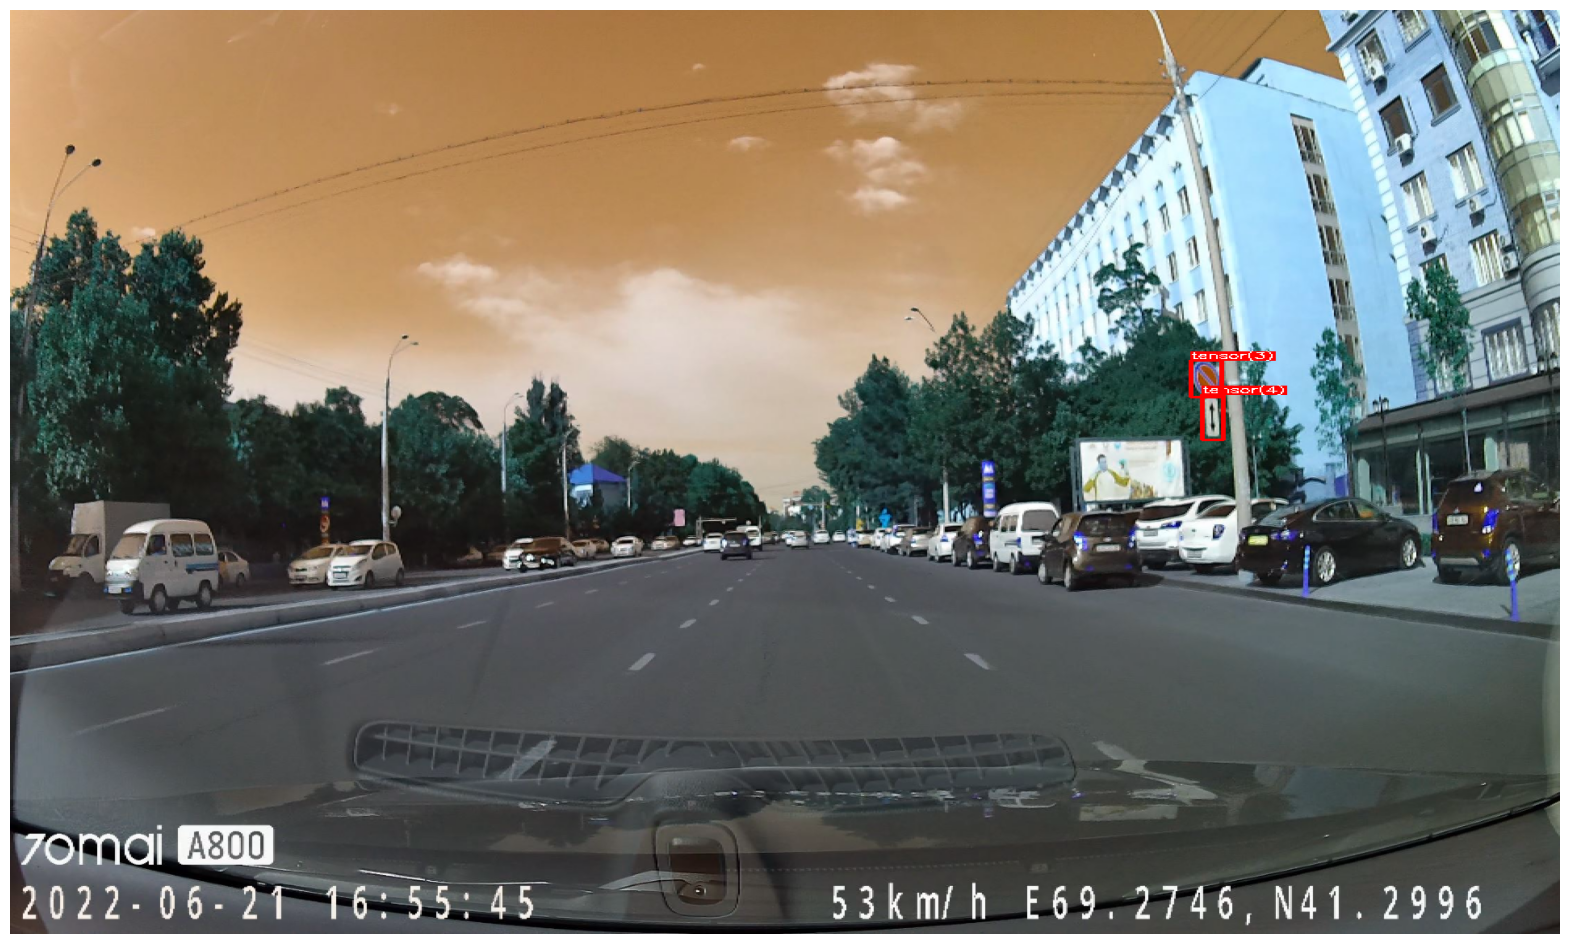

In [51]:
visualize(im.permute(1, 2, 0).numpy(), ret[0]['boxes'][:2], ret[0]['labels'][:2])